In [8]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
%matplotlib inline

In [6]:
data = pd.read_csv('../dataset/train.csv')
data[:5]

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [39]:
## Utility Methods
def squash_down_feature(feature):
    feature_mean = feature.mean()
    feature_std = feature.std()

    return [ (c_feature - feature_mean) / feature_std for c_feature in feature ]

def get_frequency_map(feature):
    freq_map = {}
    for unique_feature in set(feature):
        freq_map[unique_feature] = 0
    
    for current_feature in feature:
        freq_map[current_feature] += 1
    
    return freq_map

def get_frequency_target_map(feature, target):
    freq_map = {}
    for unique_feature in set(feature):
        freq_map[unique_feature] = 0
    
    for (current_feature, current_target) in zip(feature, target):
        if current_target == 1:
            # Counting a feature if it led to a Rainfall.
            freq_map[current_feature] += 1
    
    return freq_map

def visualize_feature(feature, against_target = False, target = []):
    freq_map = get_frequency_target_map(feature, target) if against_target else get_frequency_map(feature)
    x_points = np.array(list(freq_map.keys()))
    y_points = np.array(list(freq_map.values()))

    plt.scatter(x_points, y_points)
    plt.show()

def one_hot_encode(feature, label):
    return [1.0 if value == label else 0.0 for value in feature]

In [126]:
def format_training_data(training_data):
    return {
        'home_planet_earth': one_hot_encode(training_data['HomePlanet'], 'Earth'),
        'home_planet_mars': one_hot_encode(training_data['HomePlanet'], 'Mars'),
        'home_planet_europa': one_hot_encode(training_data['HomePlanet'], 'Europa'),
        'in_cryo_sleep': [ 1.0 if cryo_sleep else 0.0 for cryo_sleep in training_data['CryoSleep']],
        'not_in_cryo_sleep': [ 0.0 if cryo_sleep else 1.0 for cryo_sleep in training_data['CryoSleep']],
        'deck_a': [
            1.0 if mod_cabin == 'A' else 0.0 for mod_cabin in 
                [0.0 if cabin is np.nan else cabin.split('/')[0] for cabin in training_data['Cabin']]
        ],
        'deck_b': [
            1.0 if mod_cabin == 'B' else 0.0 for mod_cabin in 
                [0.0 if cabin is np.nan else cabin.split('/')[0] for cabin in training_data['Cabin']]
        ],
        'deck_c': [
            1.0 if mod_cabin == 'C' else 0.0 for mod_cabin in 
                [0.0 if cabin is np.nan else cabin.split('/')[0] for cabin in training_data['Cabin']]
        ],
        'deck_d': [
            1.0 if mod_cabin == 'D' else 0.0 for mod_cabin in 
                [0.0 if cabin is np.nan else cabin.split('/')[0] for cabin in training_data['Cabin']]
        ],
        'deck_e': [
            1.0 if mod_cabin == 'E' else 0.0 for mod_cabin in 
                [0.0 if cabin is np.nan else cabin.split('/')[0] for cabin in training_data['Cabin']]
        ],
        'deck_f': [
            1.0 if mod_cabin == 'F' else 0.0 for mod_cabin in 
                ['F' if cabin is np.nan else cabin.split('/')[0] for cabin in training_data['Cabin']]
        ],
        'deck_g': [
            1.0 if mod_cabin == 'G' else 0.0 for mod_cabin in 
                [0.0 if cabin is np.nan else cabin.split('/')[0] for cabin in training_data['Cabin']]
        ],
        'deck_t': [
            1.0 if mod_cabin == 'T' else 0.0 for mod_cabin in 
                [0.0 if cabin is np.nan else cabin.split('/')[0] for cabin in training_data['Cabin']]
        ],
        'port': [
            1.0 if mod_cabin == 'P' else 0.0 for mod_cabin in 
                [0.0 if cabin is np.nan else cabin.split('/')[2] for cabin in training_data['Cabin']]
        ],
        'starboard': [
            1.0 if mod_cabin == 'S' else 0.0 for mod_cabin in 
                ['S' if cabin is np.nan else cabin.split('/')[2] for cabin in training_data['Cabin']]
        ],
        'destination_1': [
            1.0 if destination == 'TRAPPIST-1e' else 0.0 for destination in 
                ['TRAPPIST-1e' if destination is np.nan else destination for destination in training_data['Destination']]
        ],
        'destination_2': [
            1.0 if destination == '55 Cancri e' else 0.0 for destination in 
                ['Invalid' if destination is np.nan else destination for destination in training_data['Destination']]
        ],
        'destination_3': [
            1.0 if destination == 'PSO J318.5-22' else 0.0 for destination in 
                ['Invalid' if destination is np.nan else destination for destination in training_data['Destination']]
        ],
        'age': squash_down_feature(training_data['Age'].replace(np.nan, 0.0)),
        'is_vip': [
            1.0 if vip else 0.0 for vip in 
                [False if vip is np.nan else vip for vip in training_data['VIP']]
        ],
        'not_vip': [
            1.0 if not vip else 0.0 for vip in 
                [False if vip is np.nan else vip for vip in training_data['VIP']]
        ],
        'room_service_bill': squash_down_feature(data['RoomService'].replace(np.nan, 0.0))
    }

In [127]:
formatted_training_data = format_training_data(data)
formatted_training_data.keys()

dict_keys(['home_planet_earth', 'home_planet_mars', 'home_planet_europa', 'in_cryo_sleep', 'not_in_cryo_sleep', 'deck_a', 'deck_b', 'deck_c', 'deck_d', 'deck_e', 'deck_f', 'deck_g', 'deck_t', 'port', 'starboard', 'destination_1', 'destination_2', 'destination_3', 'age', 'is_vip', 'not_vip', 'room_service_bill'])

In [128]:
def build_dataset(st, en, feature_data, target_data):
    X = []

    for i in range(st, en):
        X.append([
            feature_data['home_planet_earth'][i],
            feature_data['home_planet_mars'][i],
            feature_data['home_planet_europa'][i],
            feature_data['in_cryo_sleep'][i],
            feature_data['not_in_cryo_sleep'][i],
            feature_data['deck_a'][i],
            feature_data['deck_b'][i],
            feature_data['deck_c'][i],
            feature_data['deck_d'][i],
            feature_data['deck_e'][i],
            feature_data['deck_f'][i],
            feature_data['deck_g'][i],
            feature_data['deck_t'][i],
            feature_data['port'][i],
            feature_data['starboard'][i],
            feature_data['destination_1'][i],
            feature_data['destination_2'][i],
            feature_data['destination_3'][i],
            feature_data['age'][i],
            feature_data['is_vip'][i],
            feature_data['not_vip'][i],
            feature_data['room_service_bill'][i],

            target_data[i]
        ])
    
    return X

target_data = [ 1.0 if transported else 0.0 for transported in data['Transported']]
cleaned_training_dataset = build_dataset(0, len(data), formatted_training_data, target_data)
cleaned_training_dataset = pd.DataFrame(
    cleaned_training_dataset, 
    columns=[
        'Home Planet Earth', 
        'Home Planet Mars', 
        'Home Planet Europa',
        'In Cryo Sleep',
        'Not In Cryo Sleep',
        'Deck A',
        'Deck B',
        'Deck C',
        'Deck D',
        'Deck E',
        'Deck F',
        'Deck G',
        'Deck T',
        'Port',
        'StarBoard',
        'Destination 1',
        'Destination 2',
        'Destination 3',
        'Age',
        'Is VIP',
        'Not VIP',
        'Room Service Bill',
        'Transported'])

cleaned_training_dataset.head()

,Home Planet Earth,Home Planet Mars,Home Planet Europa,In Cryo Sleep,Not In Cryo Sleep,Deck A,Deck B,Deck C,Deck D,Deck E,...,Port,StarBoard,Destination 1,Destination 2,Destination 3,Age,Is VIP,Not VIP,Room Service Bill,Transported
0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.721943,0.0,1.0,-0.333085,0.0
1,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,-0.283953,0.0,1.0,-0.168064,1.0
2,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,1.996077,1.0,0.0,-0.267985,0.0
3,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.319585,0.0,1.0,-0.333085,0.0
4,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,-0.820430,0.0,1.0,0.125645,1.0


{'Earth': 4602, 'Mars': 1759, 'Europa': 2131, nan: 201}


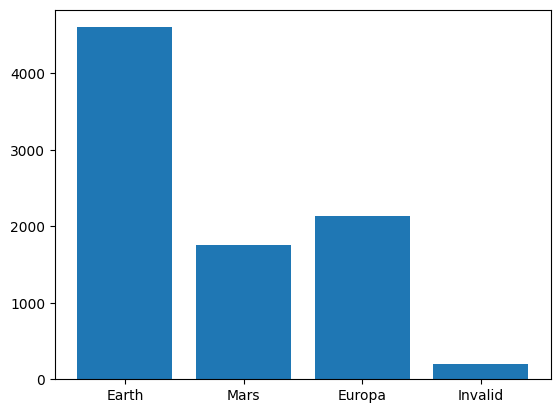

In [33]:
## Home Planet feature
def home_planet_feature():
    f_map = get_frequency_map(data['HomePlanet'])
    print(f_map)
    mod_keys = ['Invalid' if dkey is np.nan else dkey for dkey in f_map.keys()]
    plt.bar(mod_keys, [int(val) for val in f_map.values()])

home_planet_feature()

{'Earth': 4803, 'Mars': 1759, 'Europa': 2131}


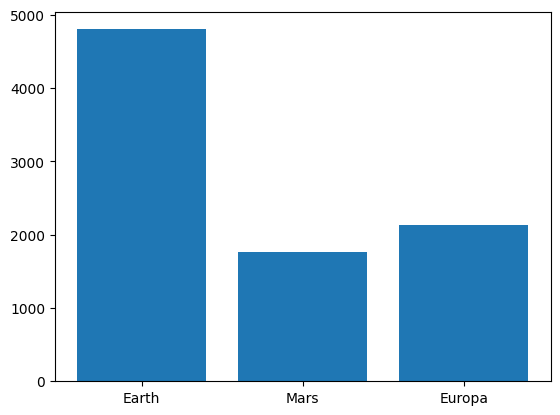

In [ ]:
# Since Earth holds majority of the Home Planet, let's replace all the Invalids with Earth
def replace_nan_with_earth():
    data['HomePlanet'] = data['HomePlanet'].replace(np.nan, 'Earth')
    f_map = get_frequency_map(data['HomePlanet'])
    print(f_map)
    plt.bar(f_map.keys(), [int(val) for val in f_map.values()])

replace_nan_with_earth()

{False: 5439, True: 3037, nan: 217}


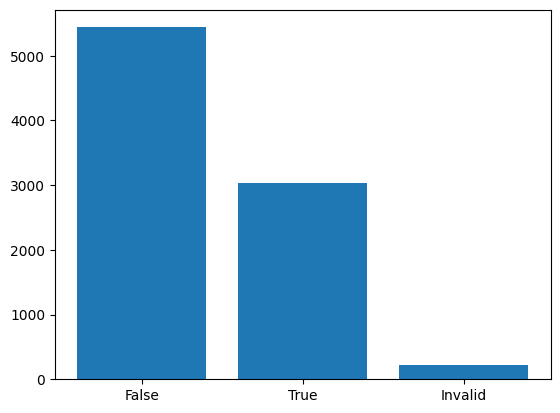

In [53]:
def cryo_sleep_feature():
    f_map = get_frequency_map(data['CryoSleep'])
    print(f_map)
    mod_keys = ['Invalid' if dkey is np.nan else str(dkey) for dkey in f_map.keys()]
    plt.bar(mod_keys, [int(val) for val in f_map.values()])

cryo_sleep_feature()

{False: 5656, True: 3037}


/var/folders/9h/5k4_qsm526q29x2g1rhnfmxr0000gn/T/ipykernel_15727/1347291414.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data['CryoSleep'] = data['CryoSleep'].replace(np.nan, False)


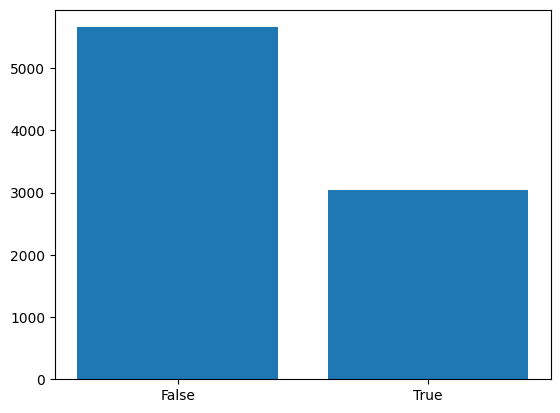

In [56]:
# Since most of the people are not in Cryo Sleep, let's replace all the Invalids with False
def replace_nan_with_false():
    data['CryoSleep'] = data['CryoSleep'].replace(np.nan, False)
    f_map = get_frequency_map(data['CryoSleep'])
    print(f_map)
    plt.bar([str(key) for key in f_map.keys()], [int(val) for val in f_map.values()])

replace_nan_with_false()

In [87]:
# Cabin - The cabin number where the passenger is staying. 
# Takes the form deck/num/side, where side can be either P for Port or S for Starboard.
get_frequency_map(['Invalid' if cabin is np.nan else cabin.split('/')[2] for cabin in data['Cabin']])

{'Invalid': 199, 'P': 4206, 'S': 4288}

In [93]:
get_frequency_map(data['Destination'])

{'55 Cancri e': 1800, 'TRAPPIST-1e': 5915, nan: 182, 'PSO J318.5-22': 796}

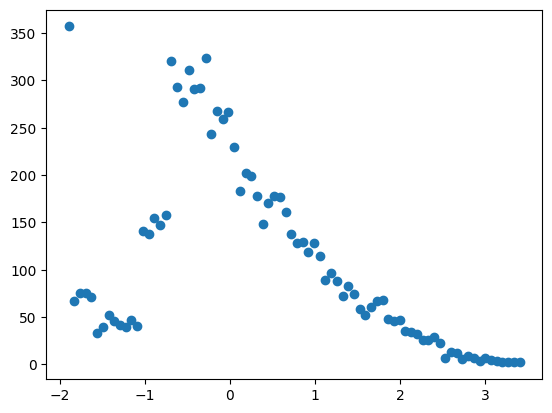

In [114]:
visualize_feature(squash_down_feature(data['Age'].replace(np.nan, 0.0)))

In [116]:
get_frequency_map(data['VIP'])

{False: 8291, True: 199, nan: 203}

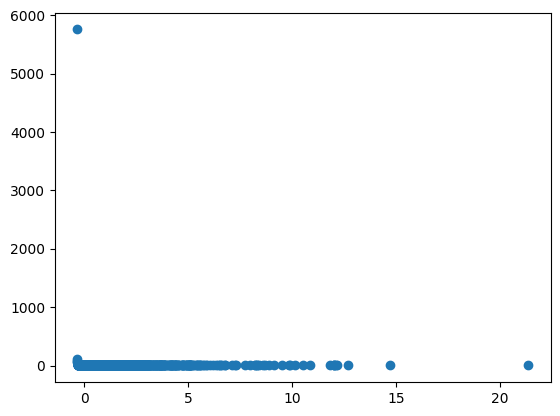

(np.float64(21.357431970648104), np.float64(-0.333085499564472))

In [129]:
squashed_down_room_service = squash_down_feature(data['RoomService'].replace(np.nan, 0.0))
visualize_feature(squashed_down_room_service)
max(squashed_down_room_service), min(squashed_down_room_service)